In [17]:
ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
from sklearn.impute import SimpleImputer                      # basic imputation method
from sklearn.impute import KNNImputer                         # k-nearest neighbour imputation method
from sklearn.experimental import enable_iterative_imputer     # required for MICE imputation
from sklearn.impute import IterativeImputer                   # MICE imputation
import os                                                     # set working directory, run executables
import math                                                   # basic math operations
import random                                                 # for random numbers
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.colors import ListedColormap                  # custom color maps
import matplotlib.ticker as mtick                             # control tick label formatting
import seaborn as sns                                         # for matrix scatter plots
from scipy import stats                                       # summary statistics
import numpy.linalg as linalg                                 # for linear algebra
import scipy.spatial as sp                                    # for fast nearest neighbor search
import scipy.signal as signal                                 # kernel for moving window calculation
from numba import jit                                         # for numerical speed up
from statsmodels.stats.weightstats import DescrStatsW
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                         # color map
seed = 73071                                                  # random seed
np.random.seed(seed=seed)

#### Training Data

In [19]:
names = {'X, m':'X','Y, m':'Y','Depth, m':'Depth','Porosity, fraction':'Por','Permeability, mD':'Perm',
             'Acoustic Impedance, kg/s-m^2':'AI','Rock facies':'Facies','Density, g/cm3':'Density','Compressible velocity, m/s':'PVel',
             'Youngs modulus, GPa':'Youngs','Shear velocity, m/s':'SVel','Shear modulus, GPa':'Shear'}

df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/res21_wells.csv') # load data from Dr. Pyrcz's GitHub repository  
df = df.rename(columns=names)
df['Por'] = df['Por'] * 100.0; df['AI'] = df['AI'] / 1000000.0; 
df['Facies'] = df['Facies'].replace({'Sandstone': 4,'Shaly sandstone': 3,'Sandy shale': 2,'Shale': 1}) # replace with ordinal categorical

df.head(n=20)

,Well_ID,X,Y,Depth,Por,Perm,AI,Facies,Density,PVel,Youngs,SVel,Shear
0,1,7325,7175,3052.8,13.330,NaN,6.981172,4.0,2.280137,3106.544655,24.721555,1690.417133,7.304717
1,1,7325,7175,3053.3,13.865,NaN,7.234749,4.0,2.135061,4003.697087,23.360728,1573.847967,5.202120
2,1,7325,7175,3053.8,14.638,NaN,7.157384,4.0,1.991045,3462.569030,28.232152,1636.279139,NaN
3,1,7325,7175,3054.3,NaN,NaN,NaN,4.0,1.694242,3836.960702,29.220132,1613.043048,5.074763
4,1,7325,7175,3054.8,14.993,NaN,NaN,4.0,1.664371,3919.585777,NaN,1636.846284,5.277834
5,1,7325,7175,3055.3,15.250,NaN,6.975785,4.0,2.165119,2850.993945,22.576821,1613.944353,NaN
6,1,7325,7175,3055.8,15.501,NaN,7.202545,4.0,1.499129,4523.602700,34.801239,1786.934783,NaN
7,1,7325,7175,3056.3,15.843,NaN,7.071741,4.0,2.279221,2880.522451,22.608217,1641.131286,7.470394
8,1,7325,7175,3056.8,16.004,NaN,6.970094,4.0,2.188753,3015.599314,23.171841,1830.396873,5.303366
9,1,7325,7175,3057.3,7.066,NaN,7.836617,2.0,3.250634,2192.474933,NaN,1649.546273,8.764372


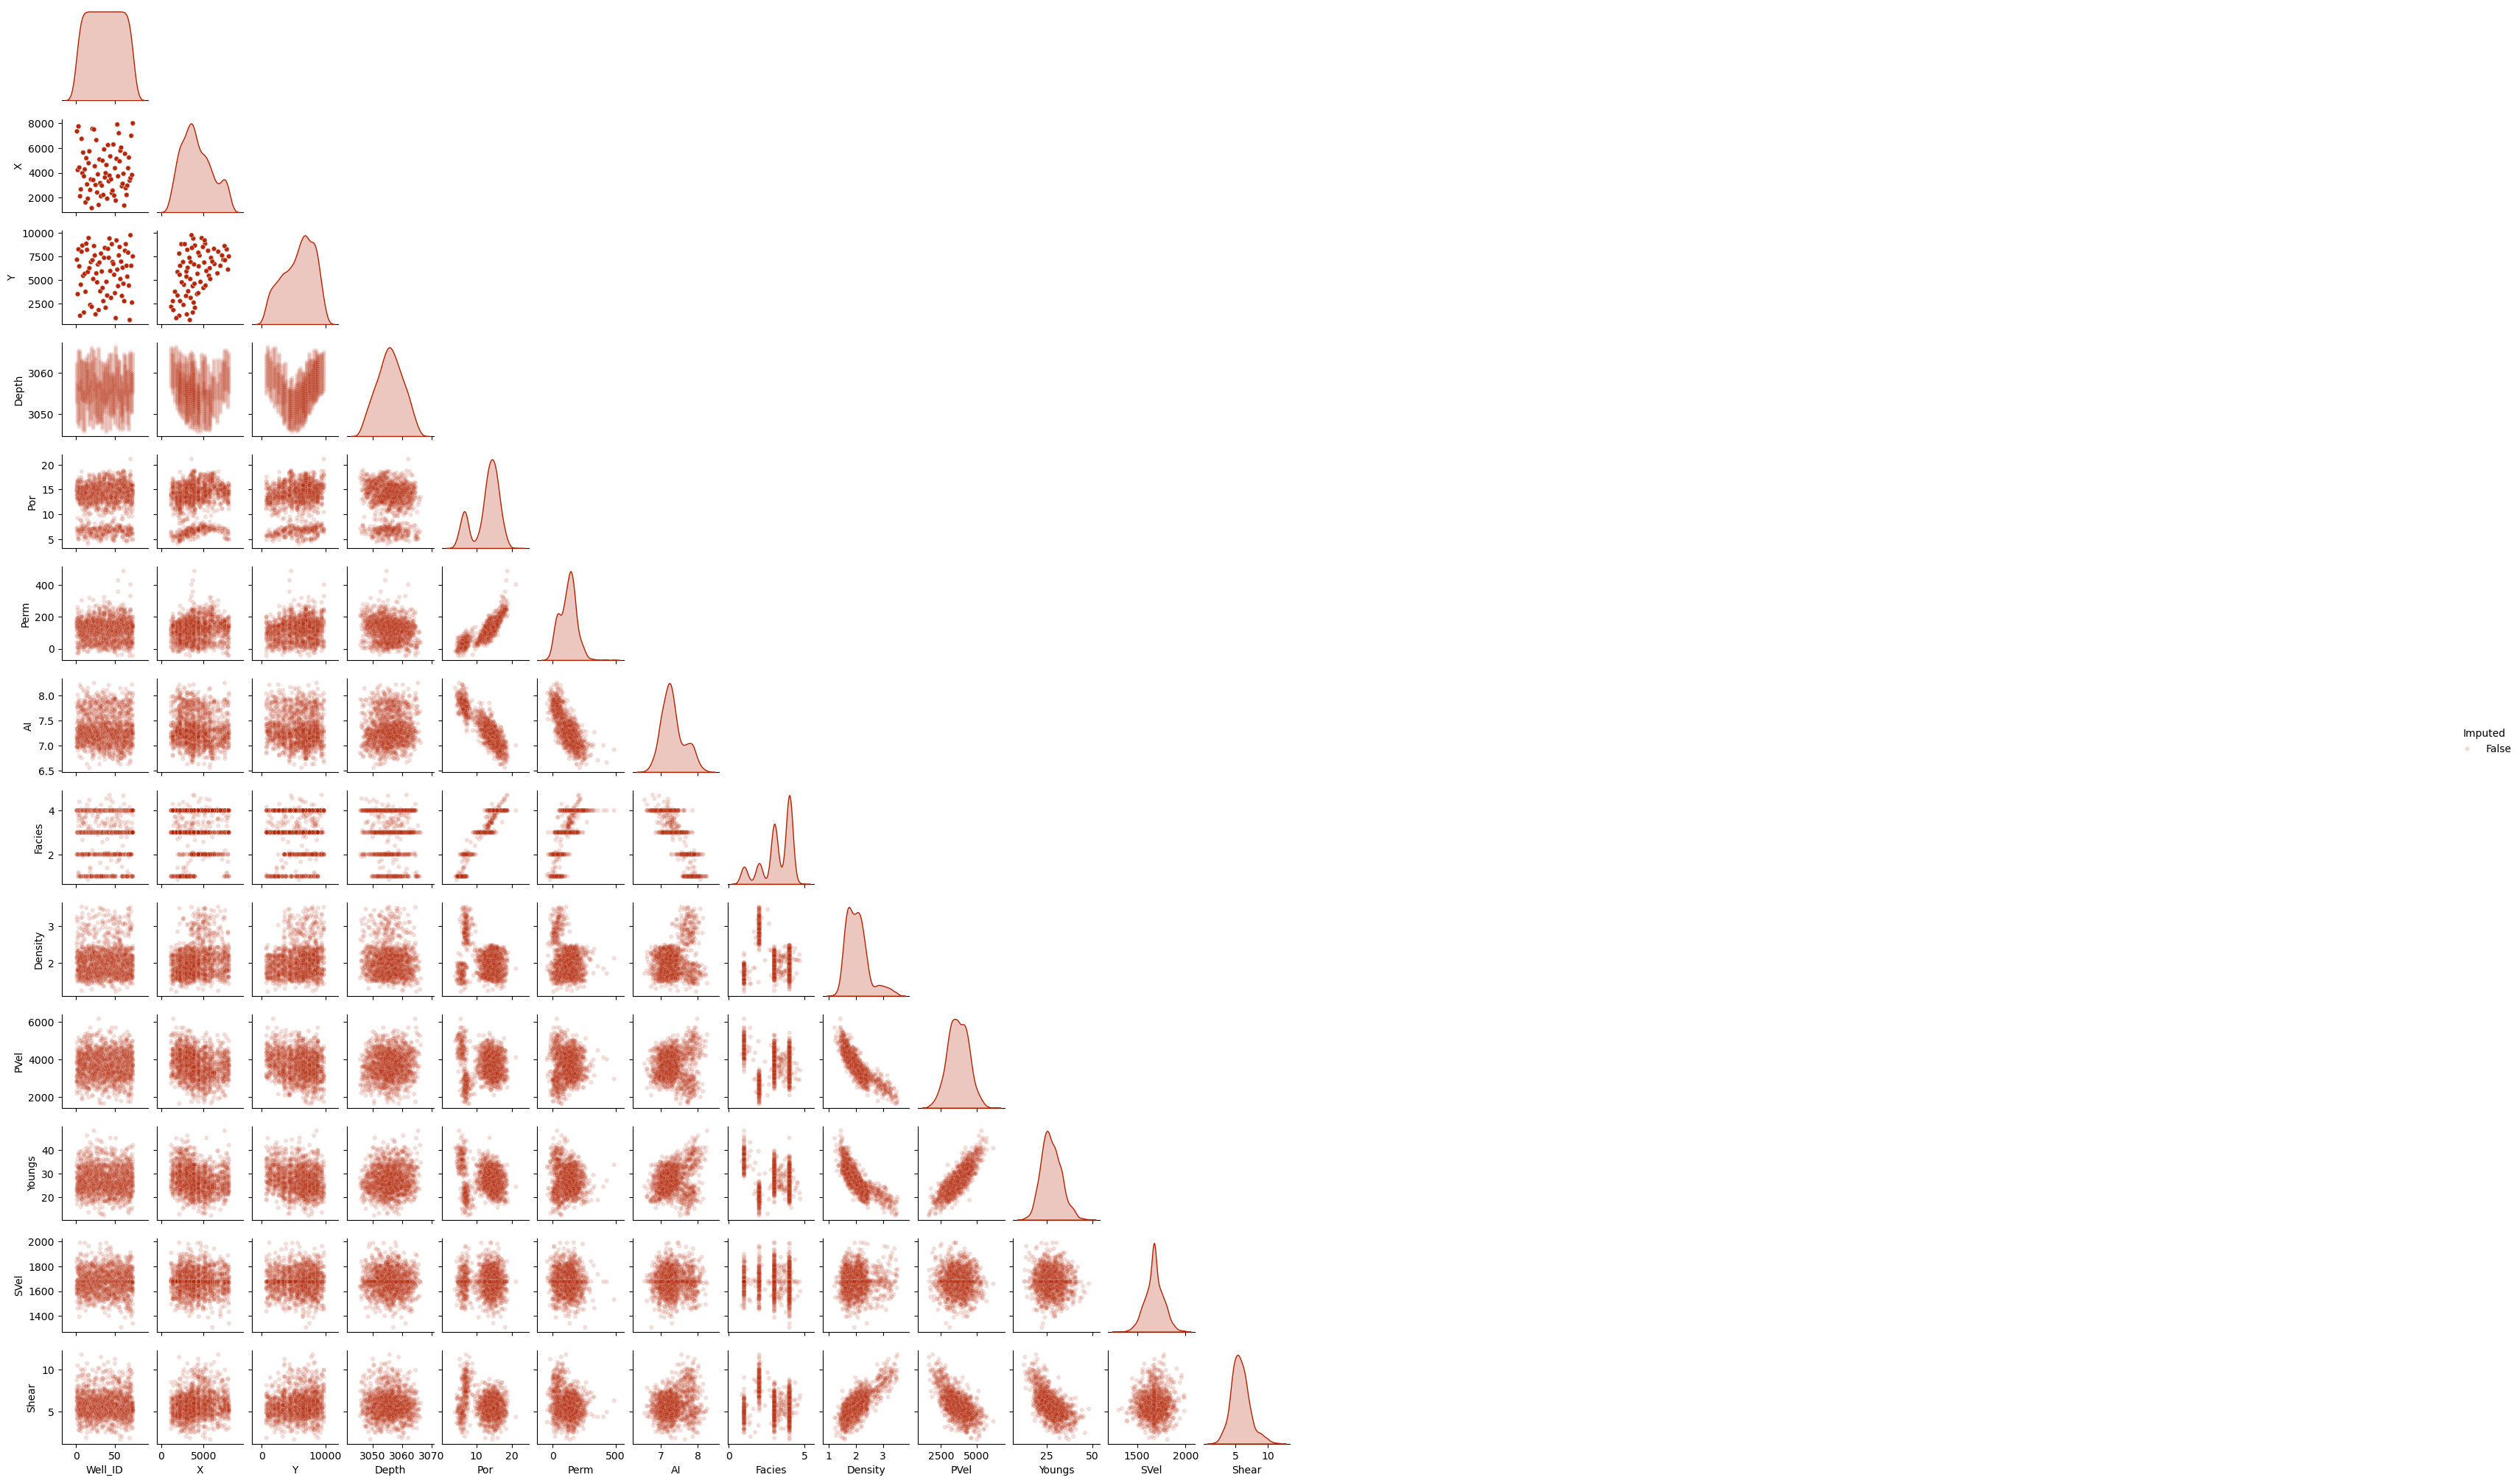

In [31]:
df_mice = df.copy(deep=True)                         # make a deep copy of the DataFrame
mice_imputer = IterativeImputer()
df_mice.iloc[:,:] = mice_imputer.fit_transform(df_mice)
df_mice['Imputed'] = (df_mice.isnull().sum(axis=1)) > 0

sns.pairplot(df_mice.iloc[:,:], hue="Imputed", plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot', corner=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)

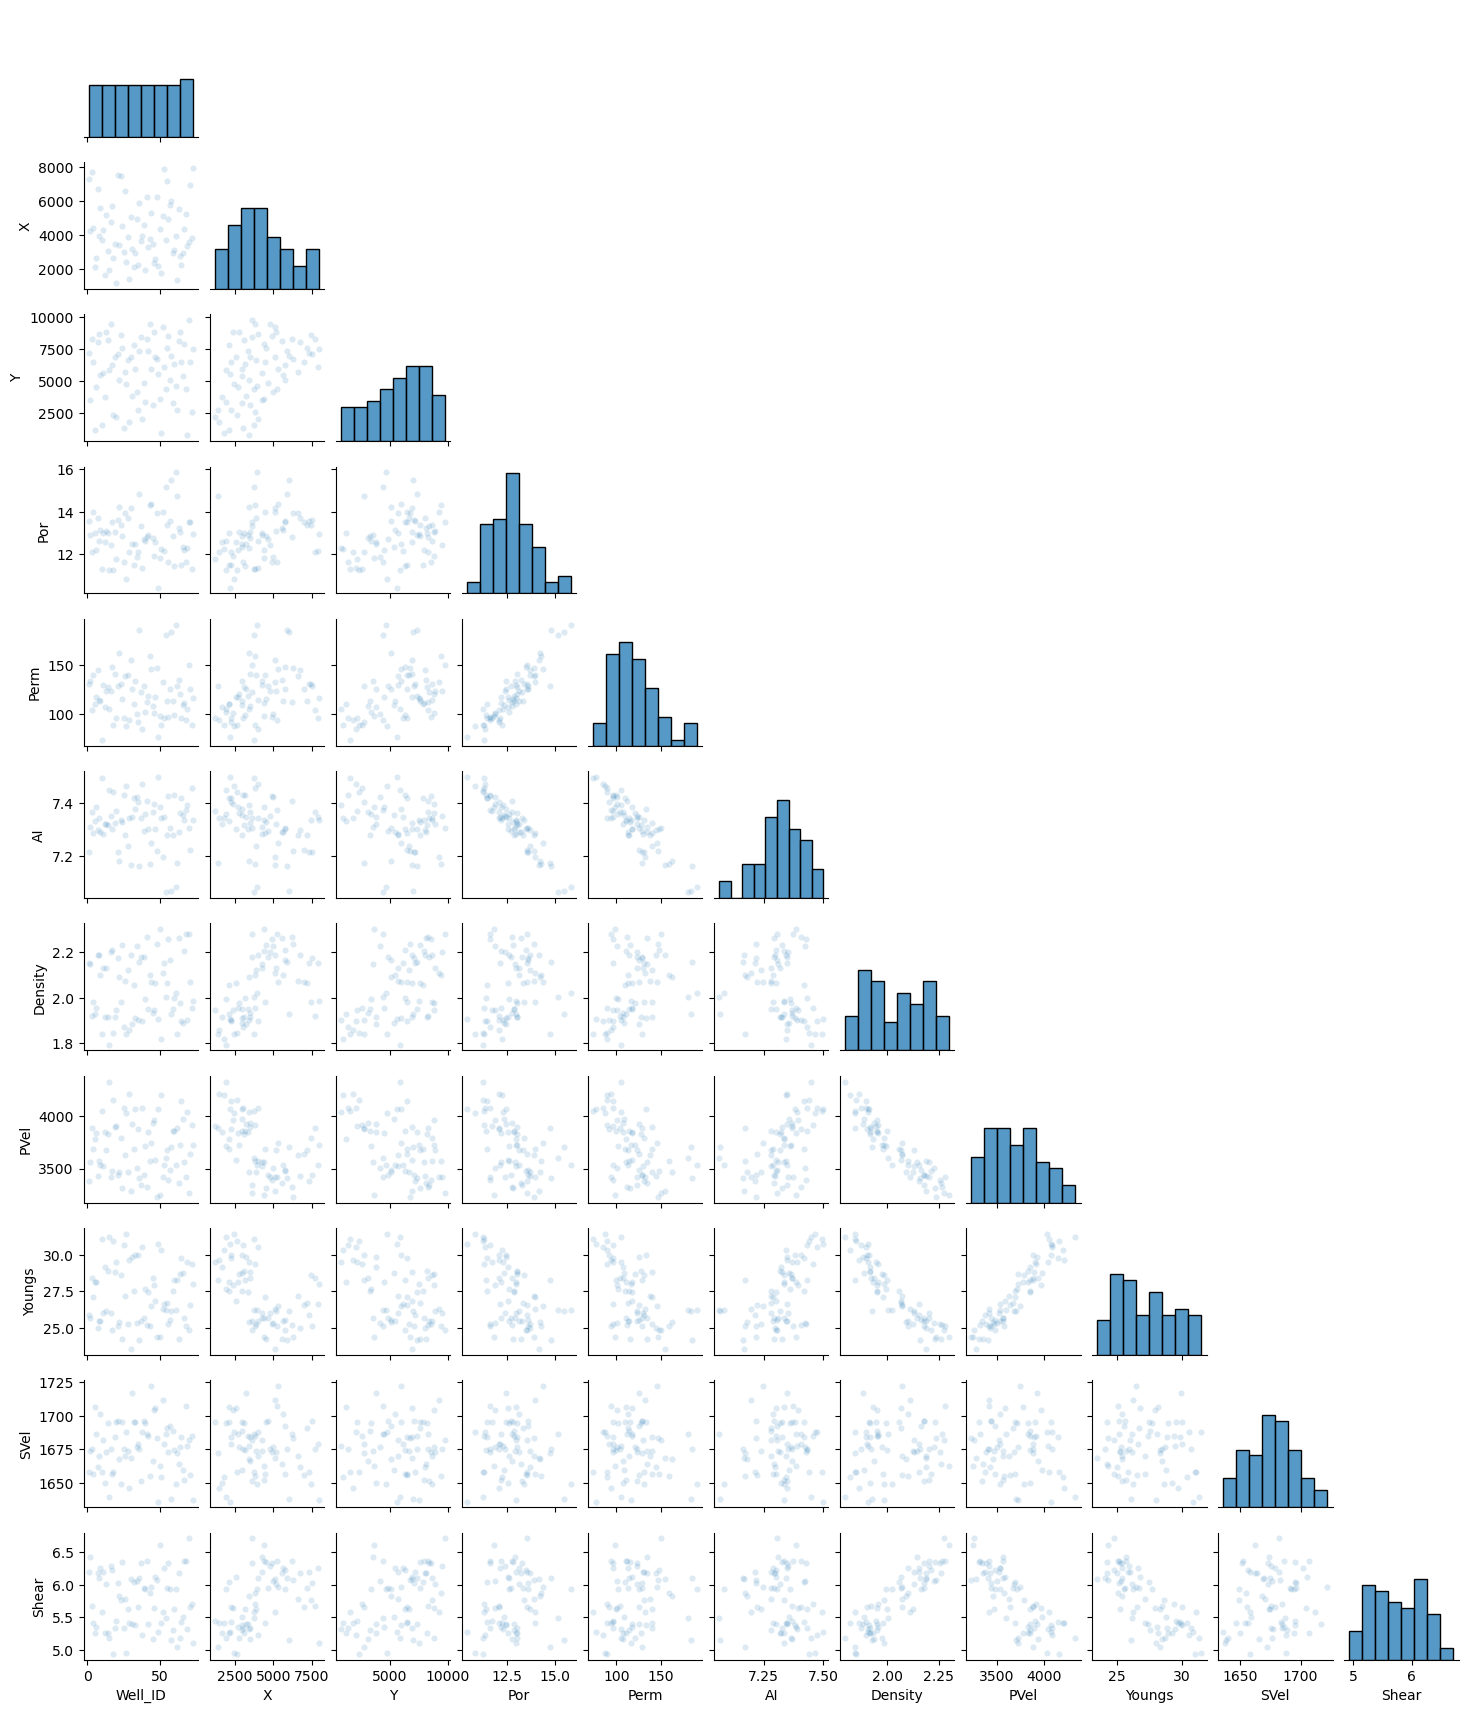

In [81]:
df_2D = df_mice.groupby('Well_ID').mean().reset_index()
df_2D.drop(['Facies','Depth','Imputed'],axis=1,inplace=True) 
df_2D.head(n=20)

sns.pairplot(df_2D.iloc[:,:], plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot', corner=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)

In [83]:
df_prod = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/res21_production_history.csv') # load data from Dr. Pyrcz's GitHub repository
df_prod.head(n=20)


,Well_ID,"Cumulative oil production (1 yr), MSTB","Cumulative oil production (2 yr), MSTB","Cumulative oil production (3 yr), MSTB","Cumulative Water production (1 yr), MSTB","Cumulative Water production (2 yr), MSTB","Cumulative Water production (3 yr), MSTB"
0,1,450.98,684.20,847.33,494.89,1236.40,2108.70
1,2,594.43,946.61,1201.20,226.97,646.50,1187.70
2,3,381.75,611.38,781.40,393.17,948.18,1603.10
3,4,795.82,1262.80,1573.20,253.25,782.38,1502.90
4,5,259.90,426.42,548.68,523.66,1187.00,1932.50
5,6,365.12,548.91,668.02,156.75,466.30,860.95
6,7,423.70,654.55,823.89,561.25,1340.60,2239.70
7,8,361.30,551.42,683.92,535.32,1285.60,2149.00
8,9,688.58,1063.00,1314.40,243.26,761.42,1459.00
9,10,229.35,388.35,518.27,222.51,528.21,880.80


In [85]:
df_2D_merge = pd.merge(df_2D, df_prod[['Well_ID', 'Cumulative oil production (3 yr), MSTB']], on='Well_ID', how='left')
df_2D_merge = df_2D_merge.rename(columns={'Cumulative oil production (3 yr), MSTB':'CumulativeOil'})
df_2D_merge.head(n=20)

,Well_ID,X,Y,Por,Perm,AI,Density,PVel,Youngs,SVel,Shear,CumulativeOil
0,1,7325.0,7175.0,13.564033,130.754882,7.214987,2.153530,3379.255305,25.875998,1658.612455,6.200409,847.33
1,2,4225.0,3525.0,12.907730,133.910637,7.308846,2.146360,3563.549461,25.688560,1673.770439,6.429229,1201.20
2,3,7725.0,8275.0,12.110566,104.059282,7.366451,1.919698,3882.442911,28.430468,1675.645601,5.674798,781.40
3,4,4425.0,6475.0,13.990654,139.915993,7.286771,1.980721,3688.351168,27.125611,1656.500842,5.408664,1573.20
4,5,2125.0,1225.0,12.982720,110.444940,7.333877,1.928716,3777.566423,28.133694,1706.678360,5.265054,548.68
5,6,2675.0,4525.0,12.225615,117.388719,7.383836,1.954708,3833.161295,28.111036,1686.523463,5.358138,668.02
6,7,6725.0,8025.0,13.686401,144.622330,7.298136,2.190057,3430.393579,25.010300,1662.280505,6.184601,823.89
7,8,3975.0,8675.0,12.647965,114.359667,7.343836,2.188597,3570.094553,25.444064,1670.043495,6.100984,683.92
8,9,5625.0,5475.0,13.127007,113.381589,7.288805,2.101103,3529.012023,25.441375,1701.601836,6.263304,1314.40
9,10,3725.0,1575.0,11.321518,73.918440,7.495025,1.841494,4051.479491,31.091104,1658.384762,5.580420,518.27


In [101]:
proportion_NaN = 0.10                                          # proportion of values in DataFrame to remove
np.random.seed(seed=seed)                                     # ensure repeatability
remove = np.random.random(df_2D_merge.shape) < proportion_NaN          # make the boolean array for removal
remove[:,[0,1,2,11]] = False
df_2D_merge_missing = df_2D_merge.mask(remove)
df_2D_merge_missing.head(n=20)

proportion_NaN = 0.30                                         # proportion of values in DataFrame to remove
np.random.seed(seed=seed)                                     # ensure repeatability
remove = np.random.random(df_2D_merge.shape) < proportion_NaN          # make the boolean array for removal
remove[:,[0,1,2,3,5,6,7,9,11]] = False
df_2D_merge_missing2 = df_2D_merge_missing.mask(remove)
df_2D_merge_missing2.head(n=20)


,Well_ID,X,Y,Por,Perm,AI,Density,PVel,Youngs,SVel,Shear,CumulativeOil
0,1,7325.0,7175.0,13.564033,NaN,7.214987,2.153530,3379.255305,25.875998,1658.612455,NaN,847.33
1,2,4225.0,3525.0,12.907730,133.910637,7.308846,2.146360,3563.549461,25.688560,1673.770439,6.429229,1201.20
2,3,7725.0,8275.0,12.110566,104.059282,7.366451,1.919698,3882.442911,NaN,1675.645601,5.674798,781.40
3,4,4425.0,6475.0,13.990654,139.915993,7.286771,1.980721,3688.351168,27.125611,NaN,5.408664,1573.20
4,5,2125.0,1225.0,12.982720,NaN,7.333877,1.928716,3777.566423,28.133694,NaN,5.265054,548.68
5,6,2675.0,4525.0,12.225615,NaN,7.383836,1.954708,3833.161295,28.111036,1686.523463,5.358138,668.02
6,7,6725.0,8025.0,13.686401,144.622330,NaN,2.190057,3430.393579,25.010300,1662.280505,6.184601,823.89
7,8,3975.0,8675.0,12.647965,114.359667,7.343836,2.188597,3570.094553,25.444064,1670.043495,6.100984,683.92
8,9,5625.0,5475.0,13.127007,113.381589,7.288805,2.101103,3529.012023,NaN,1701.601836,6.263304,1314.40
9,10,3725.0,1575.0,11.321518,NaN,7.495025,1.841494,4051.479491,NaN,1658.384762,5.580420,518.27


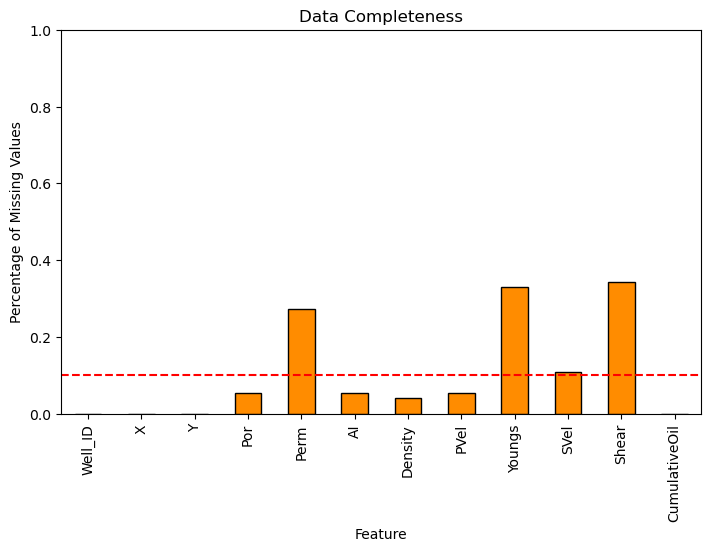

In [103]:
plt.subplot(111)                                              # data completeness plot
(df_2D_merge_missing2.isnull().sum()/len(df_2D_merge_missing2)).plot(kind = 'bar',color='darkorange',edgecolor='black') 
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Values'); plt.title('Data Completeness'); plt.ylim([0.0,1.0])
plt.plot([-0.5,df.shape[1]+0.5],[0.1,0.1],color='red',ls='--')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.8, wspace=0.2, hspace=0.2); plt.show()

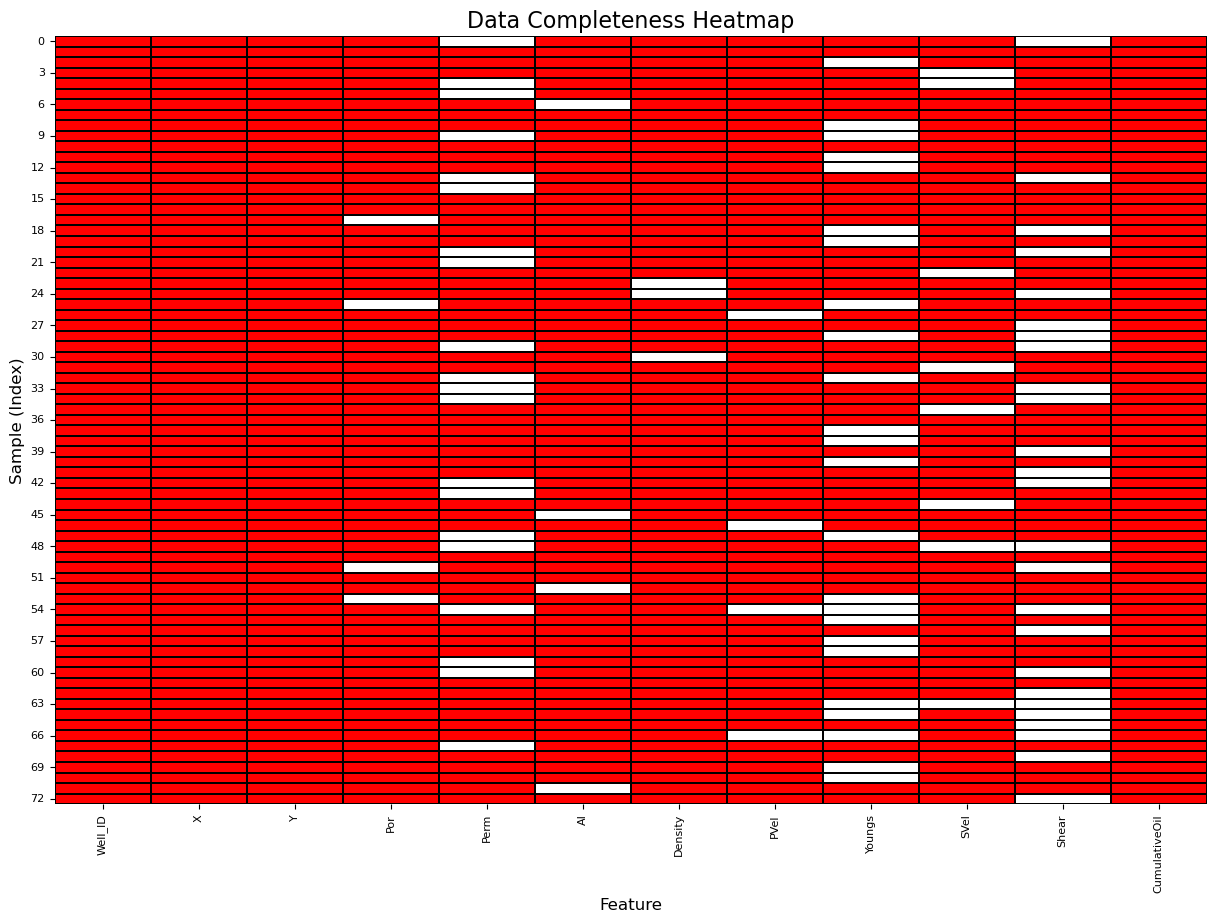

In [105]:
df_2D_merge_missing2_copy = df_2D_merge_missing2.copy(deep=True)                                  # make a deep copy of the DataFrame
df_bool = df_2D_merge_missing2_copy.isnull()                                    # true is value, false if NaN
#df_bool = df_bool.set_index(df_temp.pop('UWI'))              # set the index / feature for the heat map y column
heat = sns.heatmap(df_bool, cmap=['r','w'], annot=False, fmt='.0f',cbar=False,linecolor='black',linewidth=0.1) # make the binary heat map, no bins
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=8)
heat.set_yticklabels(heat.get_yticklabels(), rotation=0, fontsize=8)
heat.set_title('Data Completeness Heatmap',fontsize=16); heat.set_xlabel('Feature',fontsize=12); heat.set_ylabel('Sample (Index)',fontsize=12)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.6, wspace=0.2, hspace=0.2); plt.show()

In [109]:
df_2D_merge_missing2.to_csv(r'C:\Local\res21_2D_well.csv', index=False)

#### Testing Data

In [115]:
names = {'X, m':'X','Y, m':'Y','Depth, m':'Depth','Porosity, fraction':'Por','Permeability, mD':'Perm',
             'Acoustic Impedance, kg/s-m^2':'AI','Rock facies':'Facies','Density, g/cm3':'Density','Compressible velocity, m/s':'PVel',
             'Youngs modulus, GPa':'Youngs','Shear velocity, m/s':'SVel','Shear modulus, GPa':'Shear'}

df_test = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/res21_new_wells.csv') # load data from Dr. Pyrcz's GitHub repository  
df_test = df_test.rename(columns=names)
df_test['Por'] = df_test['Por'] * 100.0; df_test['AI'] = df_test['AI'] / 1000000.0; 
df_test['Facies'] = df_test['Facies'].replace({'Sandstone': 4,'Shaly sandstone': 3,'Sandy shale': 2,'Shale': 1}) # replace with ordinal categorical

df_test.head(n=20)

,Well_ID,X,Y,Depth,Por,Perm,AI,Facies,Density,PVel,Youngs,SVel,Shear
0,74,7925,5525,3050.51,NaN,NaN,7.842692,2.0,NaN,3387.576377,NaN,1646.603549,6.229941
1,74,7925,5525,3051.01,9.096,NaN,7.807355,3.0,1.872982,NaN,NaN,1465.051728,4.930174
2,74,7925,5525,3051.51,5.878,NaN,7.864859,2.0,3.187123,2660.306664,18.875428,1570.481116,7.202703
3,74,7925,5525,3052.01,NaN,NaN,7.309509,3.0,2.058578,3285.615950,26.992396,1652.096739,6.486131
4,74,7925,5525,3052.51,12.285,NaN,7.328553,3.0,1.678339,4432.429019,35.261378,1697.320552,3.802001
5,74,7925,5525,3053.01,12.562,NaN,7.660011,3.0,NaN,NaN,31.391283,NaN,NaN
6,74,7925,5525,3053.51,12.519,NaN,7.169346,3.0,1.977816,3840.180887,25.716447,1666.313834,NaN
7,74,7925,5525,3054.01,12.729,NaN,NaN,4.0,NaN,3983.286988,NaN,1830.249242,5.898287
8,74,7925,5525,3054.51,13.436,59.748051,7.027584,4.0,1.727151,3667.821993,32.492075,1691.460941,5.074222
9,74,7925,5525,3055.01,6.006,NaN,7.885494,2.0,NaN,3148.967557,23.207207,1454.617888,8.359293


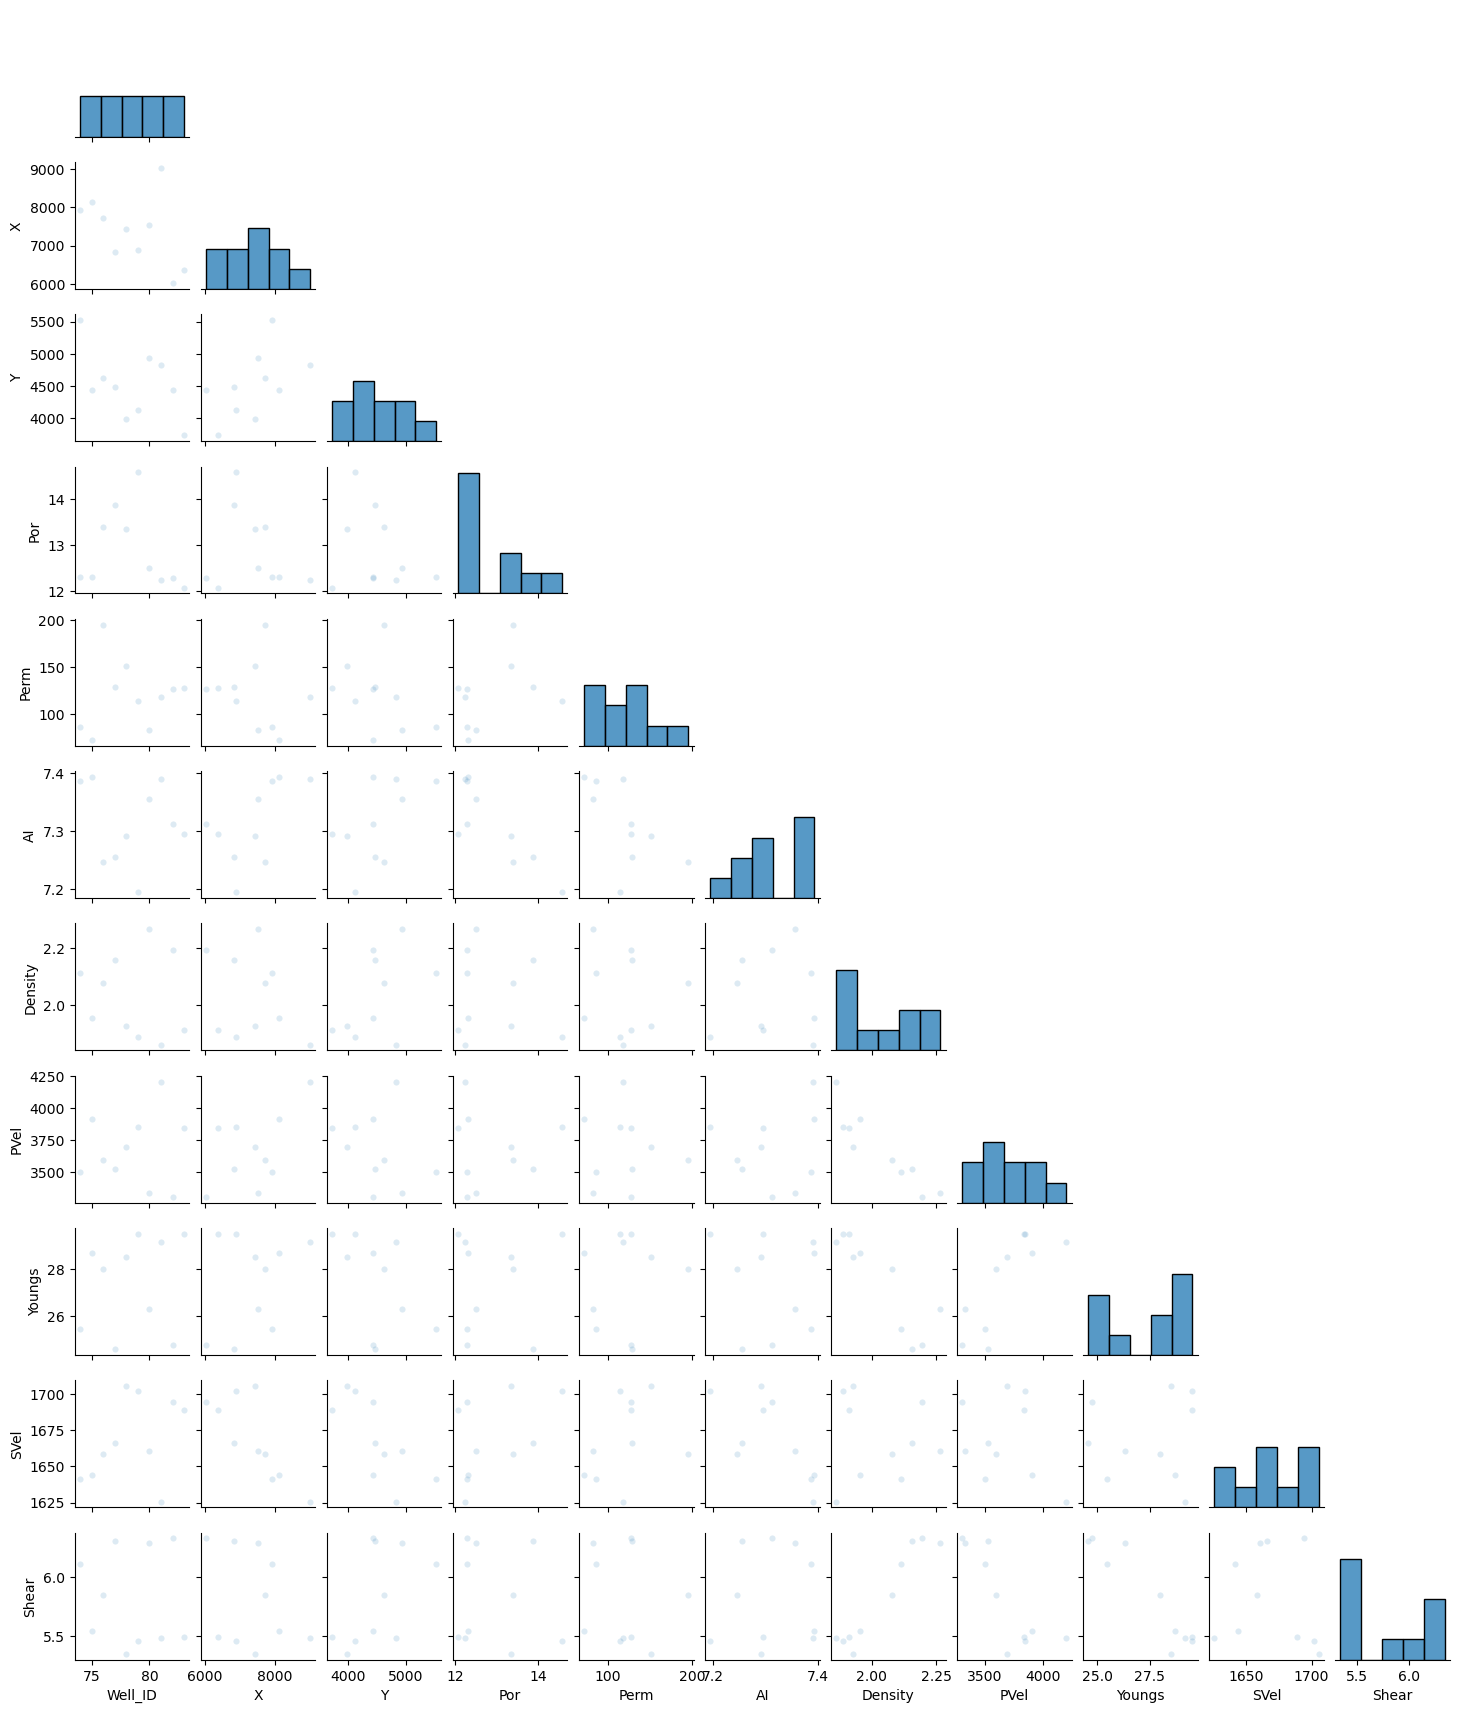

In [131]:
df_test_2D = df_test.groupby('Well_ID').mean().reset_index()
df_test_2D.drop(['Facies','Depth'],axis=1,inplace=True) 
df_test_2D.head(n=20)

sns.pairplot(df_test_2D.iloc[:,:], plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot', corner=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)

In [133]:
df_test_2D.describe()

,Well_ID,X,Y,Por,Perm,AI,Density,PVel,Youngs,SVel,Shear
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,78.50000,7385.000000,4505.000000,12.888227,120.208381,7.312129,2.035705,3675.673224,27.451897,1668.733330,5.820889
std,3.02765,888.756935,514.349643,0.858320,36.120335,0.068620,0.144272,281.302598,1.988986,27.708879,0.405087
min,74.00000,6025.000000,3725.000000,12.073750,71.992542,7.194660,1.862495,3304.759974,24.569174,1625.705857,5.345275
25%,76.25000,6837.500000,4200.000000,12.283560,93.112284,7.263776,1.915984,3504.615098,25.656353,1647.674806,5.480845
50%,78.50000,7475.000000,4450.000000,12.398912,122.190084,7.304023,2.016851,3643.822155,28.263023,1663.385145,5.693875
75%,80.75000,7875.000000,4775.000000,13.380542,128.690742,7.378976,2.146680,3846.534914,29.061416,1692.971554,6.248317
max,83.00000,9025.000000,5525.000000,14.588533,195.267385,7.393464,2.266880,4206.389963,29.529052,1705.296805,6.333516


In [137]:
proportion_NaN = 0.10                                          # proportion of values in DataFrame to remove
np.random.seed(seed=seed)                                     # ensure repeatability
remove = np.random.random(df_test_2D.shape) < proportion_NaN          # make the boolean array for removal
remove[:,[0,1,2]] = False
df_test_2D_missing = df_test_2D.mask(remove)
df_test_2D_missing.head(n=20)

proportion_NaN = 0.30                                         # proportion of values in DataFrame to remove
np.random.seed(seed=seed)                                     # ensure repeatability
remove = np.random.random(df_test_2D.shape) < proportion_NaN          # make the boolean array for removal
remove[:,[0,1,2,3,5,6,7,9]] = False
df_test_2D_missing2 = df_test_2D_missing.mask(remove)
df_test_2D_missing2.head(n=20)


,Well_ID,X,Y,Por,Perm,AI,Density,PVel,Youngs,SVel,Shear
0,74,7925.0,5525.0,12.297556,NaN,7.386720,2.113875,3497.399163,25.438942,1641.413329,NaN
1,75,8125.0,4425.0,NaN,71.992542,7.393464,1.954353,3911.754285,NaN,1644.080134,NaN
2,76,7725.0,4625.0,13.390333,195.267385,7.246248,2.079348,3592.473231,28.003328,1658.458824,NaN
3,77,6825.0,4475.0,13.870105,128.974715,7.254626,2.157615,3526.262903,24.569174,1666.223529,6.311062
4,78,7425.0,3975.0,13.351167,151.252341,7.291226,1.927381,3695.171078,NaN,1705.296805,5.345275
5,79,6875.0,4125.0,14.588533,NaN,7.194660,1.887621,3847.731545,29.519405,NaN,5.454473
6,80,7525.0,4925.0,12.495294,82.326745,7.355745,2.266880,3331.845076,NaN,1660.546761,6.292982
7,81,9025.0,4825.0,12.234105,117.458572,7.390554,1.862495,4206.389963,NaN,1625.705857,5.476935
8,82,6025.0,4425.0,12.278895,126.921596,7.312159,2.195301,3304.759974,24.742882,1694.248092,6.333516
9,83,6375.0,3725.0,12.073750,127.838824,NaN,1.912184,3842.945020,29.529052,NaN,5.492577


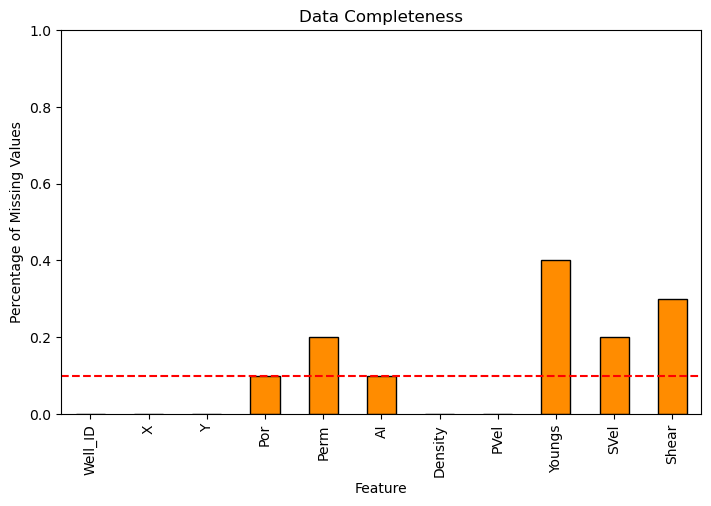

In [139]:
plt.subplot(111)                                              # data completeness plot
(df_test_2D_missing2.isnull().sum()/len(df_test_2D_missing2)).plot(kind = 'bar',color='darkorange',edgecolor='black') 
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Values'); plt.title('Data Completeness'); plt.ylim([0.0,1.0])
plt.plot([-0.5,df.shape[1]+0.5],[0.1,0.1],color='red',ls='--')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.8, wspace=0.2, hspace=0.2); plt.show()

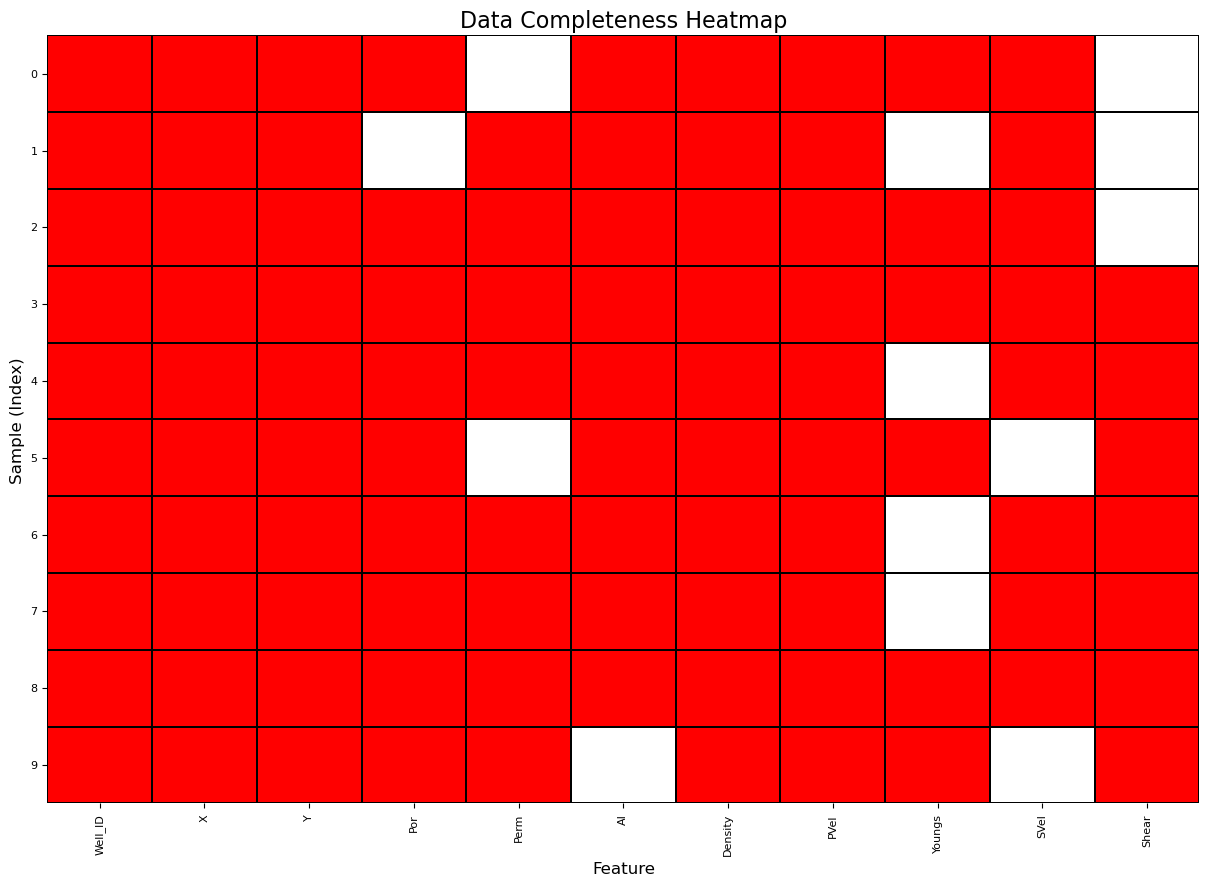

In [141]:
df_test_2D_missing2_copy = df_test_2D_missing2.copy(deep=True)                                  # make a deep copy of the DataFrame
df_bool = df_test_2D_missing2_copy.isnull()                                    # true is value, false if NaN
#df_bool = df_bool.set_index(df_temp.pop('UWI'))              # set the index / feature for the heat map y column
heat = sns.heatmap(df_bool, cmap=['r','w'], annot=False, fmt='.0f',cbar=False,linecolor='black',linewidth=0.1) # make the binary heat map, no bins
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=8)
heat.set_yticklabels(heat.get_yticklabels(), rotation=0, fontsize=8)
heat.set_title('Data Completeness Heatmap',fontsize=16); heat.set_xlabel('Feature',fontsize=12); heat.set_ylabel('Sample (Index)',fontsize=12)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.6, wspace=0.2, hspace=0.2); plt.show()

In [147]:
df_test_2D_missing2.to_csv(r'C:\Local\res21_2D_wells_test.csv', index=False)